### CS578 Preliminary Project Report

#### Authors : Kaustubh Sawant, Chowdhury Mohammad Rakin Haider, Eric Xu Han

#### Project Definition
Density functional theory (DFT) calculations are used to calculate the stability of materials and predict their existence. Unfortunately, DFT calculations are computationally expensive. Therefore, we propose to train ML methods using publicly available databases to predict the relative stability of a particular class of oxides. These are oxides consisting of two other element sans oxygen.

#### Data Acquisition
Data was acquired from the Materials Project Database. We use structural and chemical information of the compound as well of the individual element to form our feature vector. A python code was written to query the required data and tabulate it into a readable format. The stability of a compound is defined using ‘energy above hull’. If this value is below 40 meV, the compound is labelled as ‘stable’. Please find attached the code as well as the final formatted X-data and Y-labels. Each compound is identified by its chemical formula and task id.


In [1]:
%run -i data_acquisition\Data_from_pymatgen

ERROR:root:File `'data_acquisition\\Data_from_pymatgen.py'` not found.


#### Machine Learning Algorithms

We have 21016 datapoints with 17 features. Our preferred classification algorithms are SVM, Naïve Bayes and Logistic Regression. We have already implemented the algorithms using scikitlearn. PFA src/utils.py which contains the code for the same.

In [1]:
#Importing necessary modules
import pandas as pd
from src.util import get_model, train_test_split, get_xy
from src.main import get_best_param_combination
import src.constants as constants
from src.cv import k_fold_cross_validation

In [2]:
#Reading Data
df = pd.read_excel('../X_data.xlsx', index_col=0)
df = df.drop(columns=['task_id', 'formula'])
y = pd.read_excel('../y_label.xlsx', index_col=0)
df['labels'] = y[0]

The initial data was split into 80% for training and 20% for testing

In [3]:
train, test = train_test_split(df,0.2)
train_x, train_y = get_xy(train)

In our implementation, the model_type of Naive Bayes, Logistic Regression and SVM are 1, 2 and 3 respectively.

In [4]:
print('model_type for Naive Bayes is', constants.NAIVE_BAYES)
print('model_type for Logistic Regression is', constants.LOG_REGRESSION)
print('model_type for SVM is', constants.SVM)

model_type for Naive Bayes is 1
model_type for Logistic Regression is 2
model_type for SVM is 3


#### Hyper Parameters
We have tuned several hyperparameters to find out the best combination of hyper parameters for SVM and Logistic Regression. The SVM classifier contains several hyperparameters that can be tuned. Among these hyperparameters, we have tuned the regularization parameter (λ), the kernel, and for radial basis kernel we shall tune the kernel coefficient (β). For Logistic Regression Classifier we shall tune the type of regularization used (Lasso and Ridge) and the regularization parameter (λ).
The following dictionary holds all the possible values of each hyper-parameters. 

In [5]:
param_dict = {constants.LOG_REGRESSION: {
    'regularizer': ['l2', 'l1'],
    'reg_param': [.000001, 0.0001, 1, 1000, 10000, 100000, 1000000]
    },
    constants.SVM: {
        'kernel': ['linear', 'rbf', 'sigmoid'],
        'reg_param': [0.0001, 1, 1000, 10000],
        'gamma': [0.125, 0.25, 0.5, 1, 2]
    }
}
param_dict

{2: {'regularizer': ['l2', 'l1'],
  'reg_param': [1e-06, 0.0001, 1, 1000, 10000, 100000, 1000000]},
 3: {'kernel': ['linear', 'rbf', 'sigmoid'],
  'reg_param': [0.0001, 1, 1000, 10000],
  'gamma': [0.125, 0.25, 0.5, 1, 2]}}

Here, reg_param for Logistic Regression and SVM corresponds to the regularization parameter (λ). Additionally, the gamma for SVM corresponds to the kernel coefficient (β). 

#### Cross Validation
We have implemented k-fold cross validations on the training data to tune the hyperparameters. PFA the src/cv.py file, which contains the function *k_fold_cross_validation*. It takes the number of folds k, data X, labels y, and the model for which the crosss-validation needs to be performed. And returns the average accuracy and the standard deviation of the accuracies of the folds.

Lets select Logistic Regression as our first algorithm with L2 regularization and regularization constant equal to 1.

In [6]:
model = get_model(constants.LOG_REGRESSION, regularizer='l2', reg_param=1)
model

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=10000,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=47, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [7]:
acc, std=k_fold_cross_validation(5, train_x, train_y, model) #example with 5

In [8]:
print('Mean accuracy = ', round(acc*100,2))

Mean accuracy =  68.11


#### Tuning hyperparameters
We run *get_best_param_combination* to get the best parameter combination for SVM and Naive Bayes. This function takes as parameter the type of model whose hyper parameters are to be tuned and a dictionaty which conatins the hyper parameters that are to be tuned as well as a list of their possible values. The function returns a dictionary which contains the best combination of the values of the hyper parameters.

In order to get the best parameter combination, we perform 10-fold cross validation for each value of each hyper parameter while keeping all the hyper parameters fixed at a default value. For each hyper parameter, a graph is also plotted using the average accuracy and standard deviations obtained from performing cross validation using each possible value. Finally, we pick the the value of the hyper parameter that results in maximum average accuracy from cross validation. 

First we declare an empty dictionary to store the best combination of hyper parameters. 

In [9]:
best_param = {}

First we get the best parameter combination for Logistic Regression.

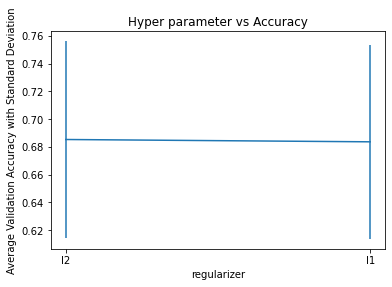

Best value for hyper paramter regularizer is l2


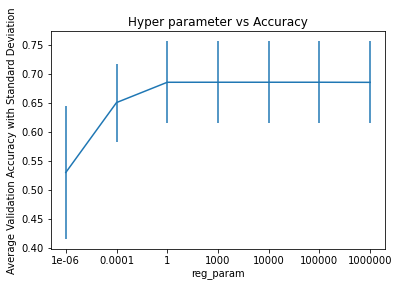

Best value for hyper paramter reg_param is 100000


{'regularizer': 'l2', 'reg_param': 100000}

In [10]:
model_type = constants.LOG_REGRESSION
param_comb = get_best_param_combination(train, model_type,
                                        param_dict[model_type])
best_param[model_type] = param_comb
param_comb

Similarly we obtain the best hyper parameter combination for SVM.

In [11]:
from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category=ConvergenceWarning)
simplefilter(action='ignore', category=FutureWarning)

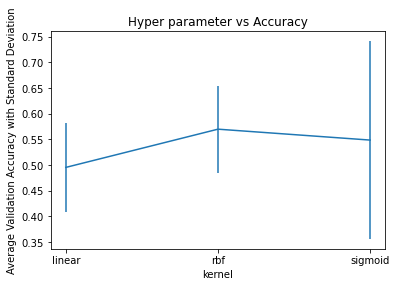

Best value for hyper paramter kernel is rbf


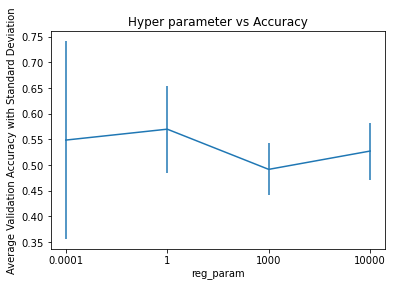

Best value for hyper paramter reg_param is 1


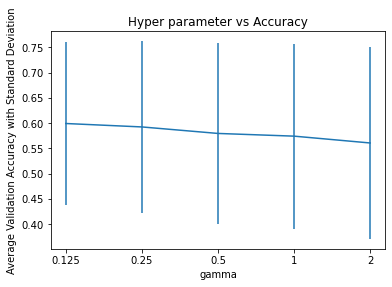

Best value for hyper paramter gamma is 0.125


{'kernel': 'rbf', 'reg_param': 1, 'gamma': 0.125}

In [12]:
model_type = constants.SVM
param_comb = get_best_param_combination(train, model_type,
                                        param_dict[model_type])
best_param[model_type] = param_comb
param_comb

Finally, we get the best hyper parameter combination in best_param. The best combinations for Logistic Regression and SVM are as follows.

In [13]:
best_param

{2: {'regularizer': 'l2', 'reg_param': 100000},
 3: {'kernel': 'rbf', 'reg_param': 1, 'gamma': 0.125}}

#### Plotting ROC Curves
The ROC curves are plotted by varying the prediction probability threshold, obtaining sensitivity and specificty for each threshold and then plotting the specificty vs sensitivity graph for each classifier. The *plot_ROC_curve* implements these steps. We first train a model using the best hyper parameter combination obtained previously. Then for each threshold, we first obatain the prediction probabilities (using sklearn *predict_proba* method) for test data using the model. For each test sample, whose predicted probability is above the threshold we assign it label 1 and 0 otherwise. Using these predicted labels and original labels of test samples, we obtain the specificity and sensitivity. In this way we obtain the specificity and sensitivity for each threshold and then plot the specificity vs sensitivity curve which is our desired ROC curve. 

In [14]:
from src.main import plot_ROC_curve

The following curve shows the ROC curve for Logistic Regression.

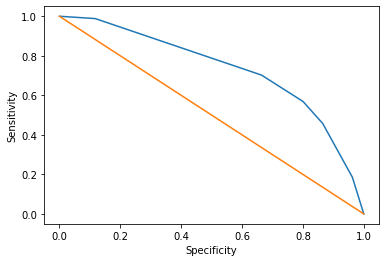

In [15]:
model_type = constants.LOG_REGRESSION
plot_ROC_curve(train, test,
               model_type, best_param[model_type])

The following curve shows the ROC curve for SVM.

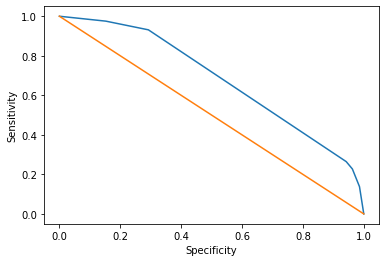

In [16]:
model_type = constants.SVM
param_dict_roc = best_param[model_type]
param_dict_roc['roc'] = True    
plot_ROC_curve(train, test,
               model_type, param_dict_roc)

A classifier is better if its ROC curve is more closer to the top-tight corner. From our ROC curves, we can comment that Logistic Regression is performing better than SVM on our dataset.

Naive Bayes classifier calculates the probability of a sample given it belongs to a certain class. Among the classes for which the conditional probability is highest, that class in selected as the predicted class. Since Naive Bayes classifier doesn't return any probability we haven't plotted any ROC curves for this classifier.

#### Test Accuracies
Using the best hyper parameter combination for Logistic Regression and SVM, we train our final models. We also train a Naive Bayes Classifier. Finally, we measure our performance on the test dataset.

In [25]:
from util import get_xy, get_confusion_mat, get_model
def get_test_accuracy(model_type, param):
    model = get_model(model_type, **param)
    train_x, train_y = get_xy(train)
    test_x, test_y = get_xy(test)
    model.fit(train_x, train_y)
    pred = model.predict(test_x)
    cnf = get_confusion_mat(test_y, pred)
    return cnf.get_accuracy()*100

In [28]:
acc = get_test_accuracy(constants.NAIVE_BAYES, {})
print('Naive Bayes Test Accyracy', round(acc,2))

Naive Bayes Test Accyracy 61.0


In [32]:
acc = get_test_accuracy(constants.LOG_REGRESSION, 
                        best_param[constants.LOG_REGRESSION])
print('Logistic Regression Test Accyracy', round(acc,2))

Logistic Regression Test Accyracy 69.38


In [34]:
acc = get_test_accuracy(constants.SVM, 
                        best_param[constants.SVM])
print('SVM Test Accyracy', round(acc,2))

SVM Test Accyracy 62.46


#### Conclusions

From the above result we can make two conclusions:
<ul>
<li>The accuracy is not very sensitive to regularization paramater (C) and the regularizer type.</li>
<li>Among the results, C = 0.6 and reg = $L2$ give the best accuracy</li>
</ul>

In [ ]:
model = get_model(constants.NAIVE_BAYES)
model

In [ ]:
S,mean,std = k_fold_cross_validation(5, train_x, train_y, model)

In [ ]:
print('Mean accuracy = ',round(mean,2))
pd.DataFrame(S)

#### Future Work

<ul>
<li>Plot ROC curves for each algorithm using the confusion matrices generated.</li>
<li>Report the best combination of hyperparameters for SVM and Logistic Regression.</li>
<li>Test data can be further divided according to the position of the cation in the periodic table.This will help to understand whether the algorithm performs better for a particular subclass like transition metals oxides.</li>
<li>Plot number of samples versus training and test error, to understand the bias-variance tradeoff of each kind of classifier.</li>
</ul>